# Comparing real and synthetic images on perceptual quality
Generating and showing grid of real and synthetic images
Interpolation of synthetic images through the latent space. Generating a synthetic image of a cervical VU and interpolating the same VU into thoracic and lumbar.

In [1]:
# Global import
import sys
import os
import torch
import re
import random
import cv2

import numpy as np
import matplotlib.pyplot as plt

from torch.nn.functional import interpolate
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import make_grid, save_image
from tqdm.notebook import tqdm

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Local import
from helpers.utils import GanMorphing

gpu = torch.cuda.is_available()
if gpu:
    os.environ['CUDA_VISIBLE_DEVICES'] = '0'
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')

if os.path.basename(os.getcwd()) != 'BDI-imaging':  # change dir to ROOT
    os.chdir("../../")
sys.path.insert(0, "src")

print('============ Demo information ============')
print('- Working directory: {}'.format(os.getcwd()))
print('- Cuda device: {}'.format(device))
print('==========================================')

# Setup
OUT_DIR = './manuscript/Fidelity/images'

============ Demo information ============
- Working directory: /home/plawija1/BDI-imaging/src
- Cuda device: cpu


In [3]:
# Batcher and datasets
from manuscript.Train.restricted.train_dataset import F2305Dataset, spineNet_split
from manuscript.Train.restricted.synthetic_dataset import SynthDataset
from manuscript.Train.batchers import F2305Batcher, A2209Batcher, SynthBatcher

# Architecture
from manuscript.Train.fixed_architecture import Generator, Discriminator

In [4]:
feature_dim = 100
# VU shape
image_shape = (9, 64, 64)
net_size = 128

netG = Generator(feature_dim=feature_dim, nc=image_shape[0], num_classes_region=3,
                 net_size=net_size, batch_norm=False)
netG.to(device)
weights = torch.load("./manuscript/Train/restricted/fixed_weights.pt",
                     map_location=torch.device('cpu'))['netG']
netG.load_state_dict(weights)

# Instanciate class
gan = GanMorphing(netG, seed = None)  # Reproducibility

### Loading training data as real example

In [5]:
batch_size=1
image_list = spineNet_split()['train']
print("Training using F2305...")
traindata_f = F2305Dataset(shape=image_shape)
print(f"Reading from {traindata_f.save_path}...")
traindata_f.prepare(label_by="reader2", types=('T1',), subset_fraction=1.0, image_list=image_list)

vu_loader_f = DataLoader(F2305Batcher(traindata_f.dataset, traindata_f.scan_path), batch_size=batch_size,
                                    shuffle=True, num_workers=1)

Training using F2305...
Reading from /home/plawija1/BDI-imaging/local_data/...


In [6]:
max_length = 1000
train_dataset = np.zeros([max_length, 9, 64, 64])
train_regions = np.zeros([max_length, 1])
for index, sample in tqdm(enumerate(vu_loader_f)):
    im = sample['im']
    region = sample['region']
    train_dataset[index,:,:,:] = im
    train_regions[index,:] = region
    if index == max_length-1:
        break

In [7]:
# Selecting real images based on region

# Selecting Cervical VUs
regions = (train_regions == 0)
temp_length = len(train_regions[train_regions == 0])
regions = regions.reshape(1000, 1, 1, 1)
bool_C = np.tile(regions, [1, 9, 64, 64])
C_real = train_dataset[bool_C].reshape(temp_length, 9, 64, 64)

# Selecting Thoracic VUs
regions = (train_regions == 1)
temp_length = len(train_regions[train_regions == 1])
regions = regions.reshape(1000, 1, 1, 1)
bool_T = np.tile(regions, [1, 9, 64, 64])
T_real = train_dataset[bool_T].reshape(temp_length, 9, 64, 64)

# Selecting Lumbar VUs
regions = (train_regions == 2)
temp_length = len(train_regions[train_regions == 2])
regions = regions.reshape(1000, 1, 1, 1)
bool_L = np.tile(regions, [1, 9, 64, 64])
L_real = train_dataset[bool_L].reshape(temp_length, 9, 64, 64)

In [8]:
def sample_real_VU(C_real, T_real, L_real, n_samples=2):
    grid_images = np.concatenate((np.random.permutation(C_real)[:2,:,:,:],
                    np.random.permutation(T_real)[:2,:,:,:],
                    np.random.permutation(L_real)[:2,:,:,:]), axis=0)
    return grid_images

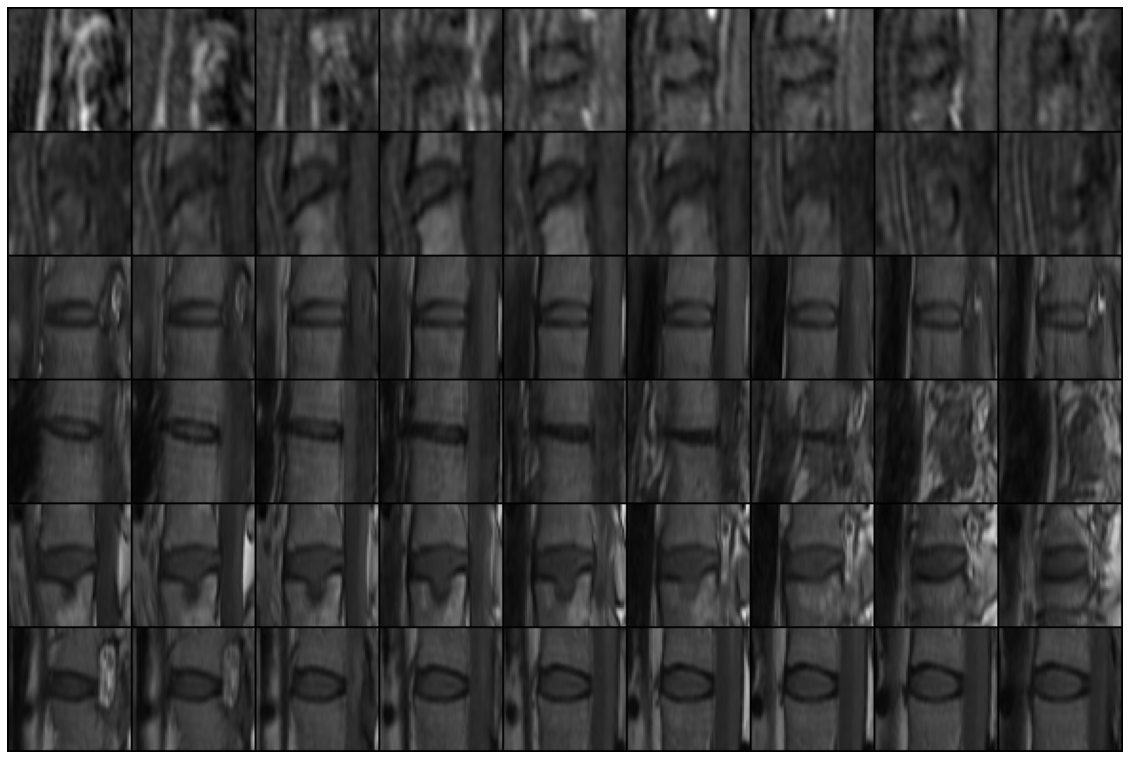

In [14]:
# Real image grid:
grid = sample_real_VU(C_real, T_real, L_real)
grid = grid.reshape(6*9,1,64,64)
grid = make_grid(torch.tensor(grid), nrow=9, normalize=True, padding=1, pad_value=0)
plt.figure(figsize=(20, 20))
plt.imshow(grid.permute(1, 2, 0))
plt.axis('off')
plt.savefig('./manuscript/Fidelity/images/real_images_grid.png', dpi=300, bbox_inches='tight')
plt.show()

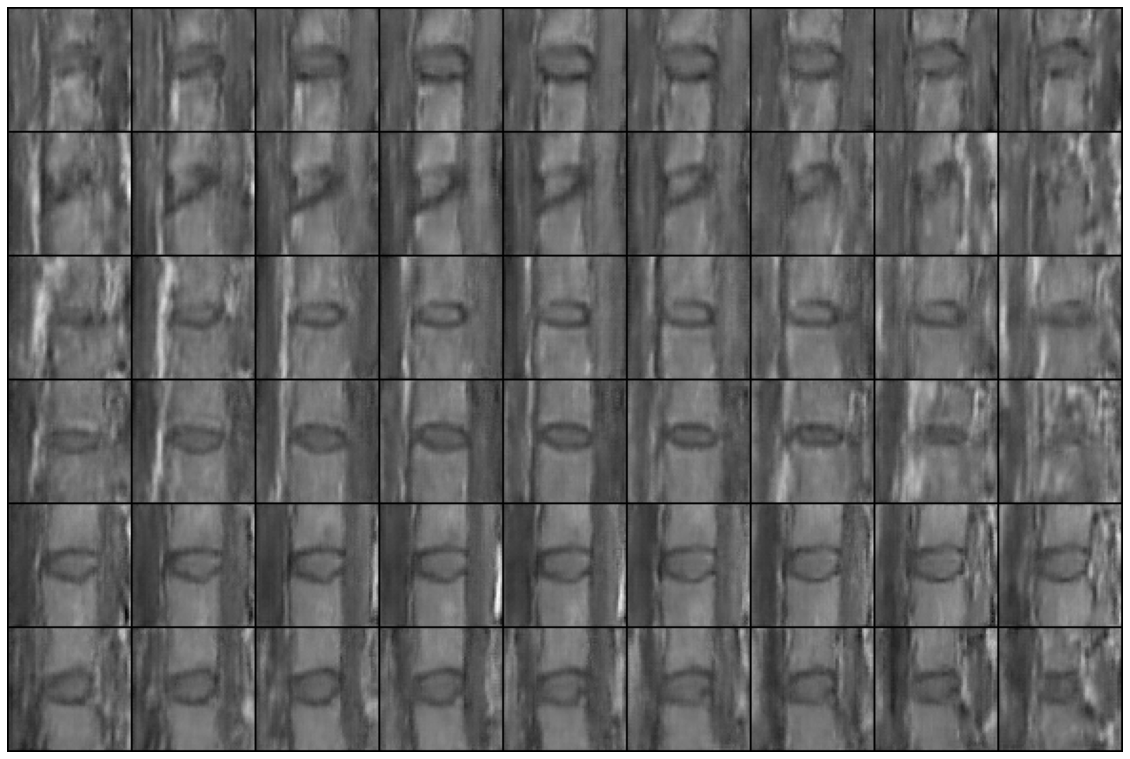

In [15]:
# Synthetic image grid:
# The synthetic images are generated using the gan wrapper
fake_samples = gan.get_fakes(n=2)
grid = make_grid(torch.tensor(fake_samples), nrow=9, normalize=True, padding=1, pad_value=0)
plt.figure(figsize=(20, 20))
plt.imshow(grid.permute(1, 2, 0))
plt.axis('off')
plt.savefig('./manuscript/Fidelity/images/synthetic_images_grid.png', dpi=300, bbox_inches='tight')
plt.show()

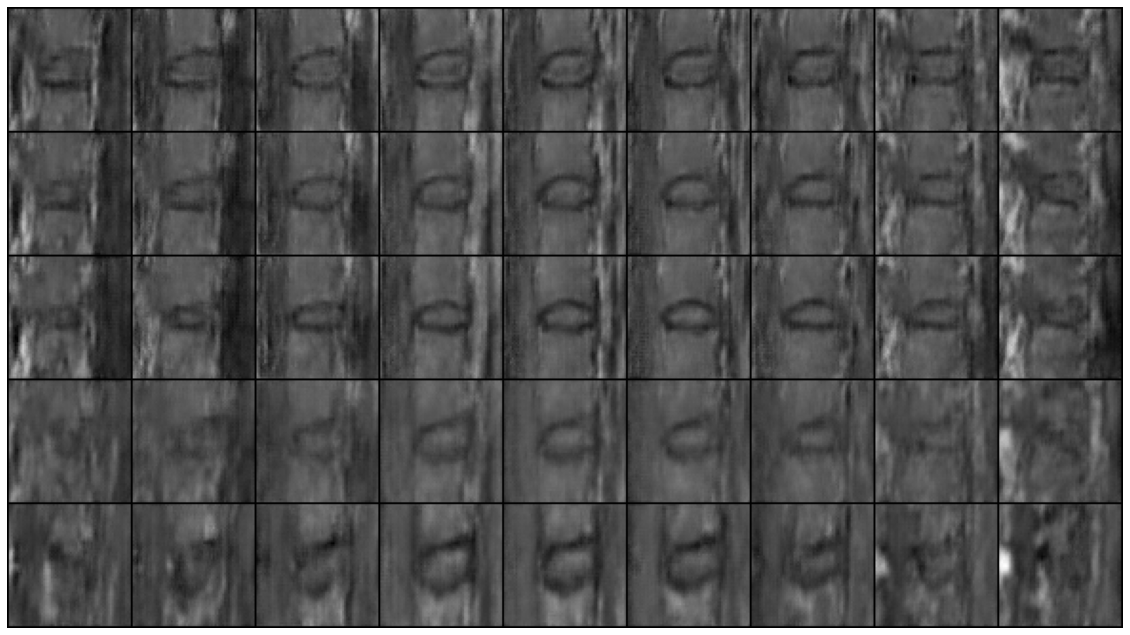

In [16]:
# Morphing image through vertebra location
# The interpolation generated using the gan wrapper
morphing = gan.morphing(steps=3)
grid =  make_grid(torch.tensor(morphing), nrow=9, normalize=True, padding=1, pad_value=0)
plt.figure(figsize=(20, 20))
plt.imshow(grid.permute(1, 2, 0), vmin=0, vmax=1)
plt.axis('off')
plt.savefig('./manuscript/Fidelity/images/interpolation_grid.png', dpi=300, bbox_inches='tight')
plt.show()